<a href="https://colab.research.google.com/github/statscol/icesi_faii_final/blob/master/fundamentos_analiticaII_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller Fundamentos de Analítica 2

## Jhon Parra - Jhon López

El dataset "TransaccionesBancarias.csv" contiene la historia transaccional de diferentes clientes a los que se les otorgó un crédito bancario. Se trata de las agregaciones de las operaciones diarias de los 3 meses (90 días) previos a la demanda del crédito. Tenemos además la fecha del crédito, el monto prestado, y una indicación de si el cliente pudo cumplir con sus obligaciones de pago o no.


## **Carga de librerías necesarias**





In [0]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from plotnine import *
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import SGDClassifier


## **Lectura de la información**

In [2]:
##READ FROM GITHUB REPO
!git clone https://github.com/statscol/icesi_faii_final
%ls

Cloning into 'icesi_faii_final'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
icesi_faii_final/  sample_data/


In [4]:
datos=pd.read_csv("icesi_faii_final/TransaccionesBancarias.csv")
datos.head()

,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_54,dia_55,dia_56,dia_57,dia_58,dia_59,dia_60,dia_61,dia_62,dia_63,dia_64,dia_65,dia_66,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,1490.23,1470.19,1744.23,0.0,0.0,0.0,-270.07,1590.93,-7581.79,-3303.89,1256.7,0.0,0.0,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,-30.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,-7.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0


## Limpieza y Transformación de la Información

In [0]:
datos=datos.set_index(['ID'])

In [0]:
#cambiar a tipo fecha
datos['fecha']=pd.to_datetime(datos.fecha) 

###creacion de variables 
datos['TotalMovMes1']=datos.iloc[:,1:31].sum(axis=1)
datos['TotalMovMes2']=datos.iloc[:,31:61].sum(axis=1)
datos['TotalMovMes3']=datos.iloc[:,61:91].sum(axis=1)

def dicotomizacion(x):
  if x>0:
    return(1)
  elif(x<0):
    return(-1)
  else:
    return(0)


VarsMovs=pd.DataFrame(datos.iloc[:,0:90].apply(lambda x:[dicotomizacion(a) for a in x],axis=0))
VarsMovs.columns=['Dico'+'_' + s1 for s1 in VarsMovs.columns]
VarsMovs.head()


VarsMovs['Mes1_NoMov']=(VarsMovs.iloc[:,0:30]==0).astype(int).sum(axis=1)
VarsMovs['Mes1_MovInt']=(VarsMovs.iloc[:,0:30]==1).astype(int).sum(axis=1)
VarsMovs['Mes1_MovOut']=(VarsMovs.iloc[:,0:30]==-1).astype(int).sum(axis=1)

VarsMovs['Mes2_NoMov']=(VarsMovs.iloc[:,30:60]==0).astype(int).sum(axis=1)
VarsMovs['Mes2_MovInt']=(VarsMovs.iloc[:,30:60]==1).astype(int).sum(axis=1)
VarsMovs['Mes2_MovOut']=(VarsMovs.iloc[:,30:60]==-1).astype(int).sum(axis=1)

VarsMovs['Mes3_NoMov']=(VarsMovs.iloc[:,60:90]==0).astype(int).sum(axis=1)
VarsMovs['Mes3_MovInt']=(VarsMovs.iloc[:,60:90]==1).astype(int).sum(axis=1)
VarsMovs['Mes3_MovOut']=(VarsMovs.iloc[:,60:90]==-1).astype(int).sum(axis=1)




In [7]:
VarsMovs=VarsMovs.reset_index()
datos=datos.reset_index()

VarsFinal=VarsMovs.loc[:,['ID','Mes1_NoMov','Mes1_MovInt','Mes1_MovOut',
                'Mes2_NoMov','Mes2_MovInt','Mes2_MovOut',
                'Mes3_NoMov','Mes3_MovInt','Mes3_MovOut']]

VarsFinal

,ID,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut
0,1,29,0,1,28,0,2,25,0,5
1,2,9,11,10,10,15,5,16,8,6
2,3,27,0,3,27,0,3,29,0,1
3,5,28,0,2,28,0,2,29,0,1
4,6,8,14,8,20,6,4,30,0,0
...,...,...,...,...,...,...,...,...,...,...
1373,1481,29,0,1,30,0,0,30,0,0
1374,1482,7,10,13,8,9,13,6,9,15
1375,1483,6,6,18,1,11,18,5,7,18
1376,1484,8,3,19,14,4,12,29,1,0


In [8]:
DatosFinal=pd.merge(datos,VarsFinal,how='left',on='ID')

DatosFinal.head()


,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_66,dia_67,dia_68,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,0.0,1224.79,-1671.22,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0


In [0]:
DatosFinal['Prom_15lastdays']=DatosFinal.iloc[:,75:91].mean(axis=1)
DatosFinal['SumMov']=DatosFinal.iloc[:,1:91].sum(axis=1)


In [10]:
#pago: cambiar a binaria. 1 si no pagó, 0 si pagó
DatosFinal['pago_m']=pd.get_dummies(DatosFinal.pago)["NO"]
DatosFinal.head()

,ID,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7,dia_8,dia_9,dia_10,dia_11,dia_12,dia_13,dia_14,dia_15,dia_16,dia_17,dia_18,dia_19,dia_20,dia_21,dia_22,dia_23,dia_24,dia_25,dia_26,dia_27,dia_28,dia_29,dia_30,dia_31,dia_32,dia_33,dia_34,dia_35,dia_36,dia_37,dia_38,dia_39,...,dia_69,dia_70,dia_71,dia_72,dia_73,dia_74,dia_75,dia_76,dia_77,dia_78,dia_79,dia_80,dia_81,dia_82,dia_83,dia_84,dia_85,dia_86,dia_87,dia_88,dia_89,dia_90,pago,fecha,monto,TotalMovMes1,TotalMovMes2,TotalMovMes3,Mes1_NoMov,Mes1_MovInt,Mes1_MovOut,Mes2_NoMov,Mes2_MovInt,Mes2_MovOut,Mes3_NoMov,Mes3_MovInt,Mes3_MovOut,Prom_15lastdays,SumMov,pago_m
0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,-3500.00,...,0.00,0.00,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,-102.00,0.0,0.0,0.00,0.00,0.0,-488.43,0.0,0.0,0.0,0.0,-20.0,-5743.11,NO,2019-04-16 10:55:50.111,150.0,-30.00,-3530.00,-6383.54,29,0,1,28,0,2,25,0,5,-398.971250,-9943.54,1
1,2,20323.83,0.00,0.00,1149.58,-807.37,1240.97,1189.47,-11766.97,0.00,0.00,-277.23,1911.71,-3333.63,1351.12,-994.11,0.00,0.00,-2584.20,1490.1,1497.91,909.02,-2552.57,0.00,0.00,1369.02,-2527.99,1349.96,-2708.84,-948.15,0.00,0.00,1751.82,1523.25,2105.0,1785.60,526.27,0.00,0.00,299.15,...,1303.49,-3220.97,1509.8,0.0,0.0,-1490.2,1509.8,0.0,0.0,-3034.03,0.0,0.0,1323.34,1323.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-04-16 16:15:32.991,100.0,-15042.20,14736.95,-10850.84,9,11,10,10,15,5,16,8,6,70.153125,9167.74,1
2,3,0.00,0.00,-7.15,-7.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-150.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-30.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-30.0,0.0,0.00,NO,2019-04-29 17:47:37.833,100.0,-194.30,-3530.00,-30.00,27,0,3,27,0,3,29,0,1,-1.875000,-3754.30,1
3,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-40.34,-138.75,0.00,0.00,0.00,0.00,-7.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,-7.0,0.0,0.00,NO,2019-04-29 20:28:54.543,100.0,-186.09,-7.00,-7.00,28,0,2,28,0,2,29,0,1,-0.437500,-200.09,1
4,6,17.02,188.69,-62.19,288.53,0.00,0.00,-266.58,-6.97,103.49,-41.82,-831.44,0.00,0.00,288.96,87.07,63.04,-630.05,960.54,0.0,0.00,32.29,14.70,-365.65,-261.43,18.39,0.00,0.00,304.50,212.35,27.61,-310.73,524.48,0.00,0.0,-230.03,6.25,84.03,-115.45,395.57,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,NO,2019-05-03 14:46:39.028,900.0,-186.70,752.36,0.00,8,14,8,20,6,4,30,0,0,0.000000,582.68,1


## Análisis Exploratorio

Se muestra el comportamiento de los pagos, se ilustra el BASELINE. Se evidencia que los datos estan desbalanceados, el 83,5% de los clientes pagan los creditos y el 16,47% no los pagan.

In [0]:
Baseline=pd.DataFrame({'Count':DatosFinal.groupby(['pago']).size()})
Baseline=Baseline.reset_index()
Baseline['Prop']=Baseline['Count']/Baseline['Count'].sum()


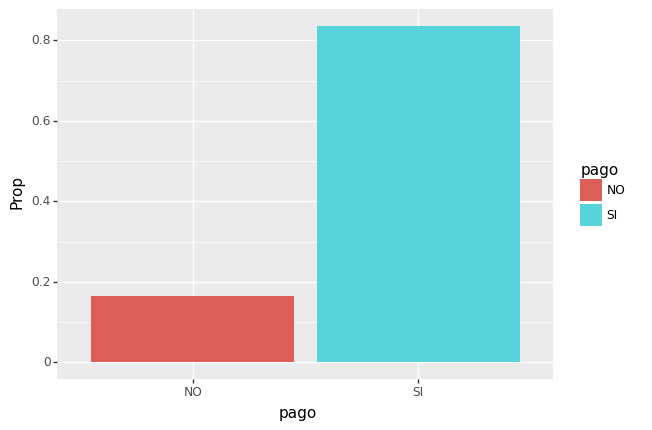

<ggplot: (8784685800603)>

In [0]:
ggplot(aes(x='pago',y='Prop',fill='pago'),data=Baseline)+\
geom_col()


Se evidencia que hay mayor concentración del no pago de los creditos en prestamos de menores montos. 

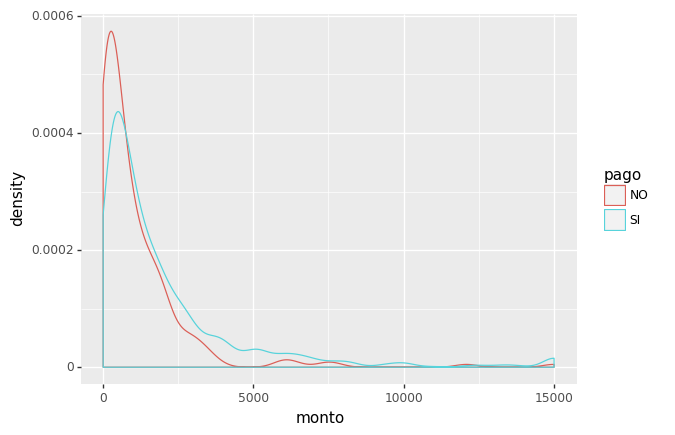

<ggplot: (8729220916947)>

In [0]:
ggplot(aes(x='monto',color='pago'),data=DatosFinal)+\
geom_density()

Se crea una variable que permita particionar el nivel del monto que se le ha prestado al cliente

In [0]:
DatosFinal['MontoCat']=DatosFinal['monto'].apply(lambda x: 'Menos de 5000' if x<=5000 else (
 '5000-10000' if x>5000 and x<=10000 else ('Mas de 10000')))

In [13]:
CuentaMontoCat=DatosFinal.groupby(['MontoCat','pago']).size().reset_index(name="count")
CategoricalDtype(categories=['Menos de 50000','5000-10000' 'Gold'], ordered=True)
CuentaMontoCat['MontoCat']=pd.Categorical(CuentaMontoCat['MontoCat'],ordered=True,categories=['Menos de 5000','5000-10000','Mas de 10000'])
CuentaMontoCat

,MontoCat,pago,count
0,5000-10000,NO,5
1,5000-10000,SI,82
2,Mas de 10000,NO,2
3,Mas de 10000,SI,28
4,Menos de 5000,NO,220
5,Menos de 5000,SI,1041


Se ilustra el comportamiento del nivel del monto prestado y si el cliente paga o no, se observa que la gran mayoria de los prestamos que no son pagados son menores a los US 5000, 5 creditos que estan entre los 5000 y los 10000 son no pagados y solo 2 de mas de 10000 no son pagados. 

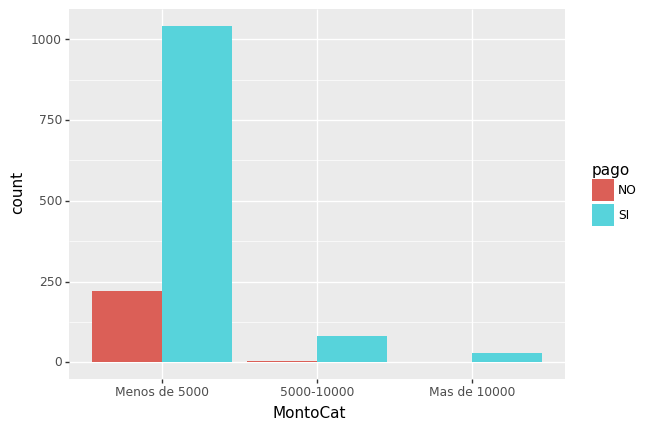

<ggplot: (-9223363250519336367)>

In [0]:
ggplot(aes(x='MontoCat',y='count',fill='pago'),data=CuentaMontoCat)+\
geom_col(position=position_dodge())

Se estudio el numeor de movimientos realizados por los clientes y se relacionan con el pago o no pago del credito

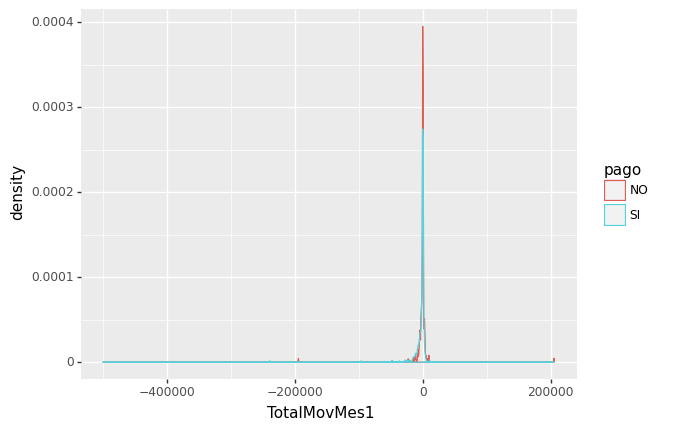

<ggplot: (8786335441721)>

In [0]:
ggplot(aes(x='TotalMovMes1',color='pago'),data=DatosFinal)+\
geom_density()

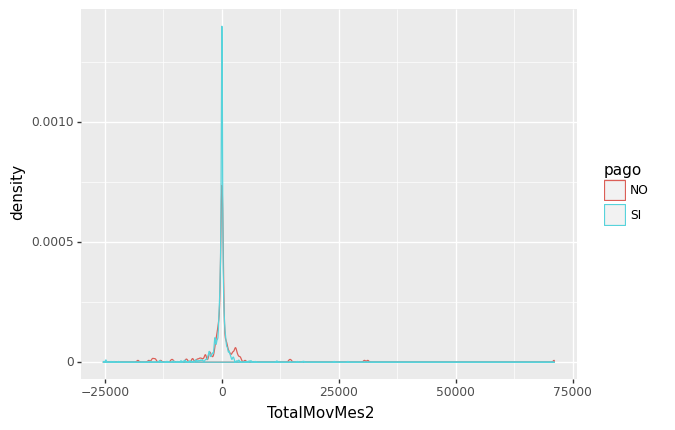

<ggplot: (-9223363250522329642)>

In [0]:
ggplot(aes(x='TotalMovMes2',color='pago'),data=DatosFinal)+\
geom_density()


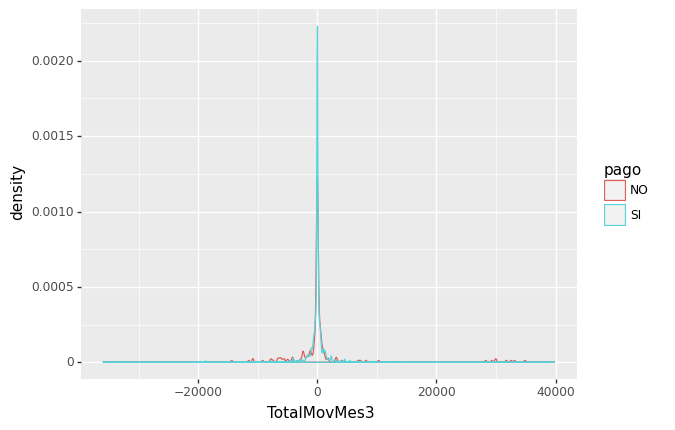

<ggplot: (8786332388437)>

In [0]:
ggplot(aes(x='TotalMovMes3',color='pago'),data=DatosFinal)+\
geom_density()


Ahora bien, se estudia el tipo de movimientos en cada uno de los meses, lo clientes pueden no tener movimientos en sus cuentas, pueden tener movimientos negativos los cuales hacen referencia a debitos en sus cuentas o pagos realizados y por ultimo, se encuentran los movimientos positivos los cuales evidencia un credito o la entrada de dinero a sus cuentas.

Clientes sin movimientos y su comportamiento de pago o no pago:

In [0]:
ggplot(aes(x='Mes1_NoMov',color='pago'),data=DatosFinal)+\
geom_density()

In [0]:
ggplot(aes(x='Mes2_NoMov',color='pago'),data=DatosFinal)+\
geom_density()

In [0]:
ggplot(aes(x='Mes3_NoMov',color='pago'),data=DatosFinal)+\
geom_density()


Clientes con movimientos positivos o creditos y su comportamiento de pago o no pago:

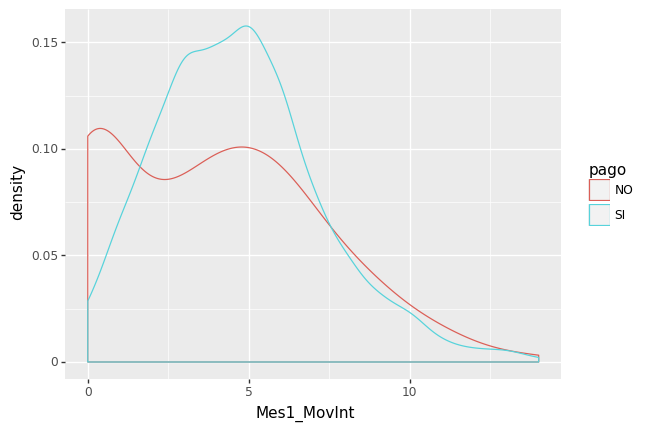

<ggplot: (-9223363254295300983)>

In [0]:
ggplot(aes(x='Mes1_MovInt',color='pago'),data=DatosFinal)+\
geom_density()



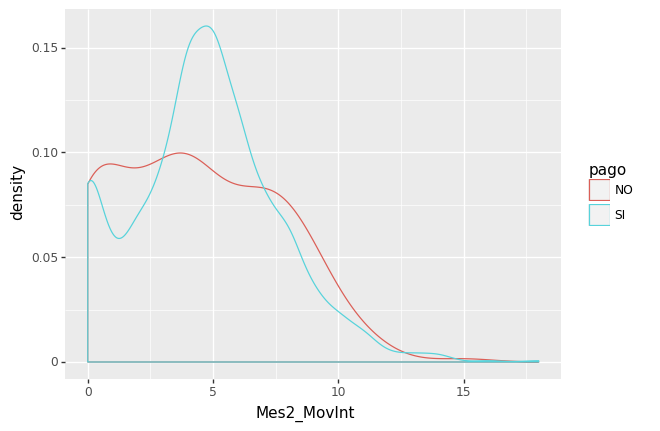

<ggplot: (8782559805490)>

In [0]:
ggplot(aes(x='Mes2_MovInt',color='pago'),data=DatosFinal)+\
geom_density()


In [0]:
ggplot(aes(x='Mes3_MovInt',color='pago'),data=DatosFinal)+\
geom_density()


Clientes con movimientos negaticos o debitos y su comportamiento de pago o no pago:

In [0]:
ggplot(aes(x='Mes1_MovOut',color='pago'),data=DatosFinal)+\
geom_density()




In [0]:
ggplot(aes(x='Mes2_MovOut',color='pago'),data=DatosFinal)+\
geom_density()


In [0]:
ggplot(aes(x='Mes3_MovOut',color='pago'),data=DatosFinal)+\
geom_density()

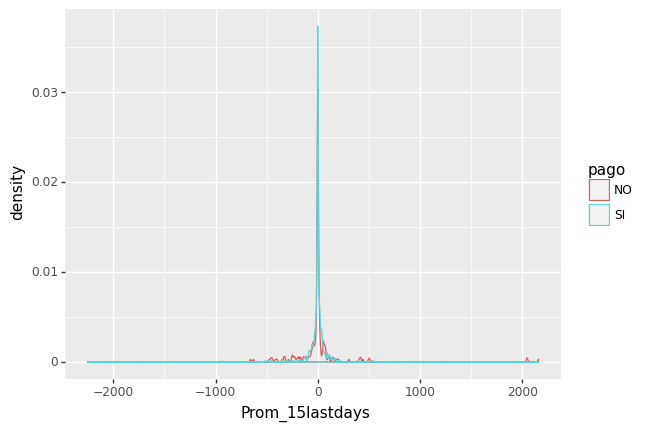

<ggplot: (-9223363250522395683)>

In [0]:
ggplot(aes(x='Prom_15lastdays',color='pago'),data=DatosFinal)+\
geom_density()

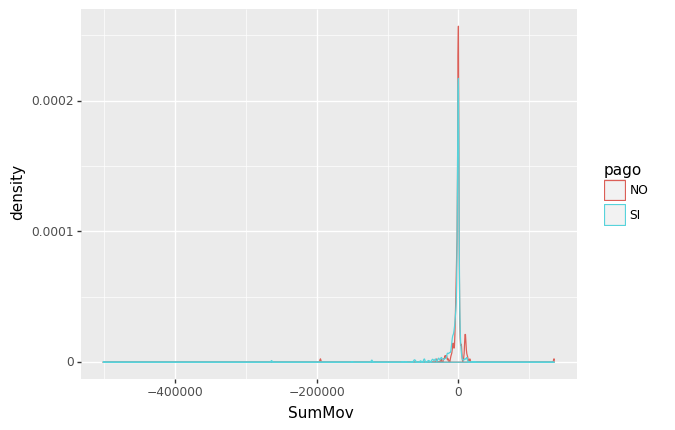

<ggplot: (-9223363250522475155)>

In [0]:
ggplot(aes(x='SumMov',color='pago'),data=DatosFinal)+\
geom_density()

### Analicemos los créditos otorgados por mes
Podemos observar que la actividad de otorgamiento tiene mayor magnitud entre julio y septiembre

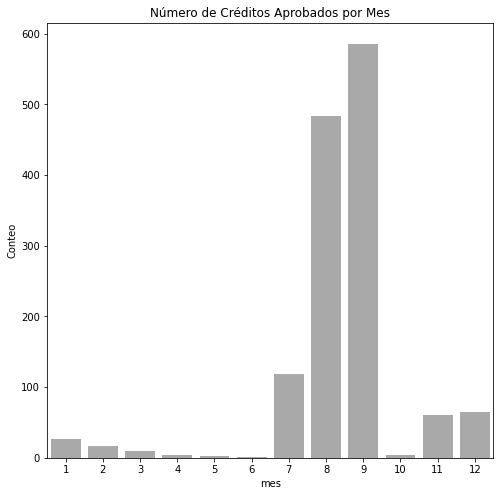

In [82]:
dataux=DatosFinal
dataux['mes']=DatosFinal.fecha.dt.month
dataux['dayweek']=DatosFinal.fecha.dt.dayofweek

ax,fig=plt.subplots(figsize=(8,8))
ax=sns.countplot(x='mes',data=dataux,color="darkgray")
ax.set_title("Número de Créditos Aprobados por Mes");
ax.set_ylabel("Conteo");

### Habrá diferencias en el comportamiento de los créditos otorgados por mes o por día?
No se observan mayores diferencias al analizar la hora del otorgamiento del crédito ni día del mes

In [0]:
def highlight(val):
  return ['background-color: red' if a>0.7 else '' for a in val] 

#por hora de aprobación
ct=pd.crosstab(DatosFinal.fecha.dt.hour,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
pago_m,,,,,,,,,,,,,,,,,,,,,,,,
0,0.862069,0.859649,0.820513,0.782609,0.826087,0.805556,0.909091,0.736842,0.956522,0.833333,0.828571,0.812500,0.567901,0.855263,0.857143,0.895833,0.793478,0.902778,0.756410,0.898305,0.842857,0.895522,0.929412,0.826923
1,0.137931,0.140351,0.179487,0.217391,0.173913,0.194444,0.090909,0.263158,0.043478,0.166667,0.171429,0.187500,0.432099,0.144737,0.142857,0.104167,0.206522,0.097222,0.243590,0.101695,0.157143,0.104478,0.070588,0.173077


In [0]:
##por día del mes
ct=pd.crosstab(DatosFinal.fecha.dt.day,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
pago_m,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.791667,0.833333,0.904762,0.875000,0.918033,0.788889,0.800000,0.852941,0.863636,0.854839,0.844444,0.901639,0.887324,0.866667,0.750000,0.838710,0.941176,0.888889,0.506329,0.857143,0.818182,0.833333,0.807692,0.941176,0.823529,0.873016,0.847458,0.871795,0.744681,0.888889,0.894737
1,0.208333,0.166667,0.095238,0.125000,0.081967,0.211111,0.200000,0.147059,0.136364,0.145161,0.155556,0.098361,0.112676,0.133333,0.250000,0.161290,0.058824,0.111111,0.493671,0.142857,0.181818,0.166667,0.192308,0.058824,0.176471,0.126984,0.152542,0.128205,0.255319,0.111111,0.105263


In [0]:
#por mes de aprobación
#parece que las personas que obtuvieron prestamos de abril a mayo, o las que lo hicieorn en noviembre, no pagan sus obligaciones
ct=pd.crosstab(DatosFinal.fecha.dt.month,DatosFinal.pago_m,normalize="index").transpose()
ct.style.apply(highlight)

fecha,1,2,3,4,5,6,7,8,9,10,11,12
pago_m,,,,,,,,,,,,
0,0.407407,0.937500,1.000000,0.000000,0.000000,0.000000,0.840336,0.838843,0.918089,0.500000,0.316667,0.784615
1,0.592593,0.062500,0.000000,1.000000,1.000000,1.000000,0.159664,0.161157,0.081911,0.500000,0.683333,0.215385


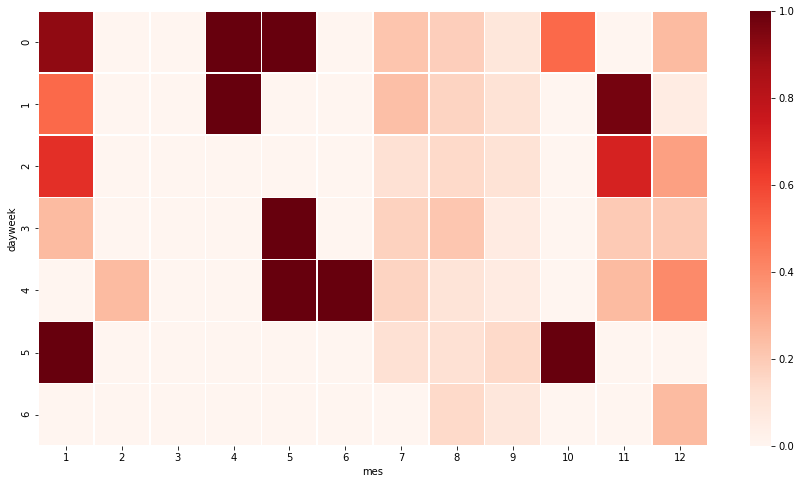

In [0]:
# vimos que existen meses en los que las personas no cumplieron con sus obligaciones. Sin embargo  veamos si este comportamiento
# puede desagregarse por día de la semana en que fue aprobado.

ct=pd.pivot_table(dataux, values='pago_m', index=['mes'],
                    columns=['dayweek'], aggfunc=np.mean).fillna(0).transpose()
import matplotlib.pyplot as plt

ax,fig=plt.subplots(figsize=(15,8))
ax=sns.heatmap(ct,cmap='Reds',linewidths=.5)

In [14]:
## Codificar monto de préstamo
le=LabelEncoder()
montocat_enc=le.fit_transform(DatosFinal.MontoCat)
DatosFinal.loc[:,'MontoCat']=montocat_enc

print("Nuevas clases transformadas:\n")

[print(j[0],":",j[1]) for j in zip(le.classes_,np.unique(montocat_enc))];


Nuevas clases transformadas:

5000-10000 : 0
Mas de 10000 : 1
Menos de 5000 : 2


## Ajuste de Modelos 

### Generación test y training set (70% train, 30% test)

In [0]:
datamodel=DatosFinal.drop(columns=['ID','pago','fecha'])

X_train, X_test, y_train, y_test = train_test_split(
    datamodel.drop(columns=['pago_m']),  # matriz con las variables predictivas
    datamodel['pago_m'], # array con los valores de la variable objetivo
    test_size=0.3,  # proporción a dejar en el test set
    random_state=123, # para controlar la semilla aleatoria
    stratify=datamodel['pago_m']) # indica la variable de estratificación estratificación de la muestra



### Metricas


In [0]:
## medir el desempeño del clasificador
def metrics(real,pred):
  kappa=cohen_kappa_score(real,pred)
  acc=accuracy_score(real,pred)
  f1=f1_score(real,pred)
  print (f" Accuracy:{acc:.4f} \n Kappa: {kappa:.4f} \n F1-Score: {f1:.4f}")



## Regresion Logistica 
```
# Esto tiene formato de código
```



In [21]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
  ('clf', LogisticRegression(penalty='l2',class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

params = {'clf__C':[0.1, 1, 10]}
grid= GridSearchCV(pipeline, params)
grid.fit(X_train,y_train)
pred_lass=grid.predict(X_test)
print(grid.best_params_)

metrics(y_test,pred_lass)


{'clf__C': 1}
 Accuracy:0.6425 
 Kappa: 0.1228 
 F1-Score: 0.3211


In [0]:
steps = [('STD', StandardScaler()), ('RIDGE', SGDClassifier(penalty="l2",early_stopping=True,validation_fraction=0.1,
                                                            max_iter=15000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'Ridge__alpha':alphas}
grid1=GridSearchCV(pipeline,param_grid=parametros,cv=5,n_jobs=-1)
grid1.fit(X_train,y_train)
pred_enet=grid1.predict(X_test)
metrics(y_test,pred_enet)


### LDA

In [0]:
## definir pasos para estandarizar los datos y entrenar el LDA
steps = [('STD', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())]
pipeline = Pipeline(steps)
##correr el pipeline
pipeline.get_params().keys()
pipeline.fit(X_train,y_train)
pred_lda=pipeline.predict(X_test)


In [0]:
metrics(y_test,pred_lda)

 Accuracy:0.8261 
 Kappa: 0.0187 
 F1-Score: 0.0526


### QDA

In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
steps = [('STD', StandardScaler()), ('QDA', QuadraticDiscriminantAnalysis())]
pipeline = Pipeline(steps)
##correr el pipeline
pipeline.get_params().keys()
pipeline.fit(X_train,y_train)
pred_qda=pipeline.predict(X_test)
metrics(y_test,pred_qda)

 Accuracy:0.7053 
 Kappa: -0.0023 
 F1-Score: 0.1757


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### SVM

SVM - Kernel Lineal

In [0]:
metrica='accuracy'
steps = [("SVM_linear", SVC(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica,n_jobs=-1)
grid1.fit(X_train, y_train)
print("score = %3.4f" %(grid1.score(X_test,y_test)))
print(grid1.best_params_)

SVM - Kernel RBF

In [0]:
metrica='accuracy'
steps = [("SVM_linear", SVC(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica,n_jobs=-1)
grid1.fit(X_train, y_train)
print("score = %3.4f" %(grid1.score(X_test,y_test)))
print(grid1.best_params_)

ValueError: ignored

Kernel - Kernel Polinomial 

In [0]:
metrica='accuracy'
steps = [("SVM_linear", SVC(kernel="poly"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica,n_jobs=-1)
grid1.fit(X_train, y_train)
print("score = %3.4f" %(grid1.score(X_test,y_test)))
print(grid1.best_params_)

SVM - Kernel Sigmoid

In [0]:
metrica='accuracy'
steps = [("SVM_linear", SVC(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica,n_jobs=-1)
grid1.fit(X_train, y_train)
print("score = %3.4f" %(grid1.score(X_test,y_test)))
print(grid1.best_params_)

### RIDGE Y LASSO: ELASTIC NET

In [0]:
### Clasificador con regularización l1 y l2 por elastic net: regresión logística y SVM
steps = [('STD', StandardScaler()), ('ELNET', SGDClassifier(penalty="elasticnet",early_stopping=True,validation_fraction=0.1))]
pipeline = Pipeline(steps)
parametros={'ELNET__loss':['log','hinge','squared_hinge'],
            'ELNET__l1_ratio':np.linspace(0,1,11)}
grid1=GridSearchCV(pipeline,param_grid=parametros,cv=5,n_jobs=-1)
grid1.fit(X_train,y_train)
pred_enet=grid1.predict(X_test)
metrics(y_test,pred_enet)



 Accuracy:0.7681 
 Kappa: 0.0909 
 F1-Score: 0.2258


In [0]:
#revisar cuál fue el modelo que tuvo el mejor comportamiento de los ajustados en ElasticNet
grid1.best_estimator_.get_params()['ELNET']

StandardScaler(copy=True, with_mean=True, with_std=True)

### REDES NEURONALES

A partir de los últimos 90 días del comportamiento, analizaremos la probabilidad de que una persona no pague sus obligaciones, a través del uso de una red neuronal convencional (MLP) y una recurrente (LSTM).

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

np.random.seed(1234)
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=1000,)
mlp.fit(X_train.iloc[:,0:90],y_train)

y_pred = mlp.predict(X_test.iloc[:,0:90])
metrics(y_test,y_pred)

 Accuracy:0.7536 
 Kappa: 0.1801 
 F1-Score: 0.3289


Ahora veamos cómo se comporta una Red Neuronal Recurrente, para ello debemos redimiensionar la base de entrenamiento, de forma que el input tenga 3 dimensiones. En el caso de la variable de respuesta, debemos tener una matriz con número de columnas igual al número de clases, con valores binarios en donde aplique cada categoría.

In [23]:
from tensorflow.keras.utils import to_categorical

sc=StandardScaler()
X_train2=sc.fit_transform(X_train.iloc[:,0:90])
X_test2=sc.transform(X_test.iloc[:,0:90])
print("Dimensión original de la base: ",X_train2.shape)

##Redimensionar para que la red neuronal tome valores de entrenamiento en dimensión (90 días, 1 registro)
X_train2=np.reshape(X_train2,(-1,90,1))
X_test2=np.reshape(X_test2,(-1,90,1))
y_train2=to_categorical(y_train,2)
y_test2=to_categorical(y_test,2)
print("Dimensión transformada de la base: ",X_train2.shape)

Dimensión original de la base:  (964, 90)
Dimensión transformada de la base:  (964, 90, 1)


In [50]:
from tensorflow.keras.layers import LSTM,Dense,Conv1D,TimeDistributed,Dropout,BatchNormalization,Flatten
from tensorflow.keras.models import Sequential

mod=Sequential()
## capa convolucional que recorre cada 8 días los picos de actividad más relevantes
mod.add(Conv1D(filters=64,input_shape=(X_train2.shape[1],1),kernel_size=8,activation="relu"))
mod.add(LSTM(50,return_sequences=True))
mod.add(Dropout(0.5))
mod.add(LSTM(50,return_sequences=True))
mod.add(Dropout(0.5))
mod.add(LSTM(50,return_sequences=False))
mod.add(Dropout(0.5))
mod.add(Flatten())
mod.add(Dense(1,activation="sigmoid"))

opt=tf.keras.optimizers.RMSprop(
    learning_rate=0.001
)
cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

mod.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

mod.fit(
    X_train2,
    y_train,
    validation_split = 0.1,
    epochs = 50,
    batch_size = 20,
    callbacks=[cb]
)

Epoch 1/50
44/44 [==============================] - 6s 140ms/step - loss: 0.4709 - accuracy: 0.8304 - val_loss: 0.5194 - val_accuracy: 0.7938
Epoch 2/50
44/44 [==============================] - 5s 119ms/step - loss: 0.4606 - accuracy: 0.8397 - val_loss: 0.5190 - val_accuracy: 0.7938
Epoch 3/50
44/44 [==============================] - 5s 117ms/step - loss: 0.4564 - accuracy: 0.8397 - val_loss: 0.5381 - val_accuracy: 0.7938
Epoch 4/50
44/44 [==============================] - 5s 120ms/step - loss: 0.4442 - accuracy: 0.8397 - val_loss: 0.5358 - val_accuracy: 0.7938
Epoch 5/50
44/44 [==============================] - 5s 118ms/step - loss: 0.4433 - accuracy: 0.8385 - val_loss: 0.5537 - val_accuracy: 0.7938
Epoch 6/50
44/44 [==============================] - 5s 119ms/step - loss: 0.4340 - accuracy: 0.8431 - val_loss: 0.5287 - val_accuracy: 0.7938
Epoch 7/50
44/44 [==============================] - 5s 120ms/step - loss: 0.4300 - accuracy: 0.8397 - val_loss: 0.5395 - val_accuracy: 0.7938
Epoch 

In [51]:
### Revisemos la estructura del modelo
mod.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 83, 50)            450       
_________________________________________________________________
lstm_6 (LSTM)                (None, 83, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 83, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 83, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 83, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)               

In [58]:
##Predecir valores de prueba y realizar métricas
y_pred_lstm_proba=mod.predict(X_test2)
#y_pred_lstm=np.argmax(y_pred_lstm,axis=1)


y_pred_lstm=np.where(y_pred_lstm_proba>0.5,1,0)

metrics(y_test,y_pred_lstm)

 Accuracy:0.8406 
 Kappa: 0.2512 
 F1-Score: 0.3265


## Analicemos la curva ROC

El valor de corte entre 0.5 y 0.6 parece ser un valor adecuado bajo el trade-off entre la sensibilidad y especificidad 



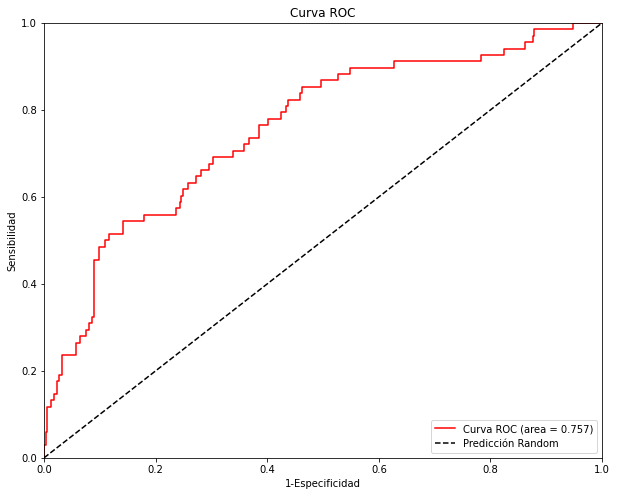

In [106]:
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm_proba)
roc_auc = roc_auc_score(y_test, y_pred_lstm_proba)

# Plot ROC curve

ax,fig=plt.subplots(figsize=(10,8))
ax=plt.plot(fpr, tpr, label='Curva ROC (area = %0.3f)' % roc_auc, color="red");
ax=plt.plot([0, 1], [0, 1], '--',color="black",label="Predicción Random") 
ax=plt.xlim([0.0, 1.0])
ax=plt.ylim([0.0, 1.0])
ax=plt.xlabel('1-Especificidad')
ax=plt.ylabel('Sensibilidad')
ax=plt.title('Curva ROC')
ax=plt.legend(loc="lower right")



### STACKING: 
Vamos a utilizar los tres modelos más precisos para elaborar un modelo final que establezca la probabilidad de pago usando toda la información disponible.